In [32]:
from pystencils.session import *
import time

In [33]:
dh = ps.create_data_handling(domain_size=(600, 600), periodicity=True)
μ_field = dh.add_array('mu', latex_name='μ')
c_field = dh.add_array('c')


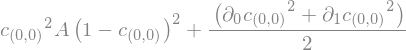

In [34]:
κ, A = sp.symbols("κ A")

c = c_field.center
μ = μ_field.center

def f(c):
    return A * c**2 * (1-c)**2

bulk_free_energy_density = f(c)
grad_sq = sum(ps.fd.diff(c, i)**2 for i in range(dh.dim))
interfacial_free_energy_density = κ/2 * grad_sq

free_energy_density = bulk_free_energy_density + interfacial_free_energy_density
free_energy_density


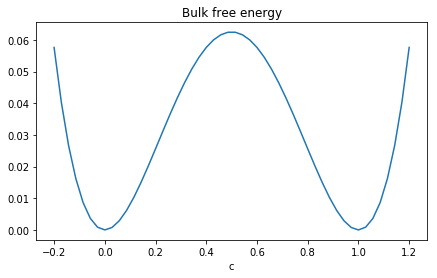

In [35]:
plt.figure(figsize=(7,4))
plt.sympy_function(bulk_free_energy_density.subs(A, 1), (-0.2, 1.2))
plt.xlabel("c")
plt.title("Bulk free energy");

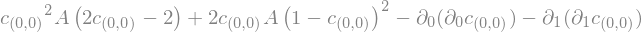

In [36]:
ps.fd.functional_derivative(free_energy_density, c)

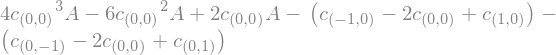

In [37]:
discretize = ps.fd.Discretization2ndOrder(dx=1, dt=0.01)

μ_update_eq = ps.fd.functional_derivative(free_energy_density, c)
μ_update_eq = ps.fd.expand_diff_linear(μ_update_eq, constants=[κ])  # pull constant κ in front of the derivatives
μ_update_eq_discretized = discretize(μ_update_eq)
μ_update_eq_discretized

In [38]:
μ_kernel = ps.create_kernel([ps.Assignment(μ_field.center,
                                           μ_update_eq_discretized.subs(A, 1).subs(κ, 0.5))]
                           ).compile()

In [39]:
M = sp.Symbol("M")
cahn_hilliard = ps.fd.transient(c) - ps.fd.diffusion(μ, M)
cahn_hilliard

In [40]:
c_update = discretize(cahn_hilliard)
c_update


In [41]:
c_kernel = ps.create_kernel([ps.Assignment(c_field.center,
                                           c_update.subs(M, 1))]
                           ).compile()

In [42]:
def init(value=0.4, noise=0.02):
    for b in dh.iterate():
        b['c'].fill(value)
        np.add(b['c'], noise*np.random.rand(*b['c'].shape), out=b['c'])

In [43]:
def init(value=0.4, noise=0.02):
    for b in dh.iterate():
        b['c'].fill(value)
        np.add(b['c'], noise*np.random.rand(*b['c'].shape), out=b['c'])

In [44]:
def timeloop(steps=100):
    c_sync = dh.synchronization_function(['c'])
    μ_sync = dh.synchronization_function(['mu'])
    for t in range(steps):
        c_sync()
        dh.run_kernel(μ_kernel)
        μ_sync()
        dh.run_kernel(c_kernel)
    return dh.gather_array('c')
init()


In [45]:
start = time.clock()
if 'is_test_run' in globals():
    timeloop(10)
    result = None
else:
    ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=600)
    result = ps.jupyter.display_as_html_video(ani)
end = time.clock()
result

In [46]:
print(end-start)

431.54621000000003
